In [1]:
import torch
import torch.nn as nn
import math
from torchviz import make_dot

# Сеть с множеством выходов 

Если сеть имеет множество выходов, то backward по их сумме эквивалентен backward-у по каждой из них 

## Пример 

In [2]:
criterion = nn.MSELoss()

In [3]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
    
    def right(self,x):
        a = torch.tanh(x)
        b = torch.tan(a)
        return b.sum()
        
    def center(self,x):
        a = torch.tan(x)
        b = torch.cos(a)
        return b.mean()
    
    def left(self,x):
        a = torch.cos(x)
        b = torch.tanh(a)
        return b.sum()
        
    
    def forward(self, x):
        a = torch.sin(x)
        c = 2 * a
        loss1 = self.left(c[:8])
        loss2 = self.center(c[8:16])
        loss3 = self.right(c[16:24])
        return loss1, loss2, loss3

In [4]:
model = TinyModel()

In [5]:
def get_losses():
    torch.manual_seed(89)
    input = torch.linspace(0., 2. * math.pi, steps=24, requires_grad=True)
    loss1, loss2, loss3 = model(input)
    return input, loss1, loss2, loss3

In [6]:
def print_graph(x):
    return make_dot(x, params=dict(model.named_parameters()))

### backward по сумме ошибок

In [7]:
input, loss1, loss2, loss3 = get_losses()

In [8]:
loss = loss1 + loss2 + loss3

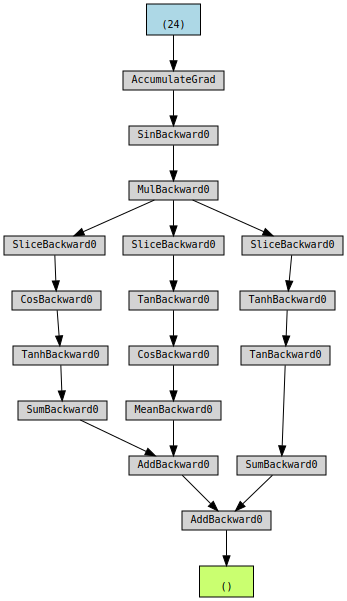

In [9]:
print_graph(loss)

In [10]:
loss.backward()
grad1 = input.grad.clone()
print(grad1)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


### backward по каждому выходу

In [11]:
input, loss1, loss2, loss3 = get_losses()

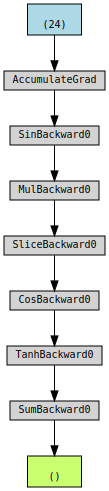

In [12]:
print_graph(loss1)

In [13]:
loss1.backward(retain_graph=True)

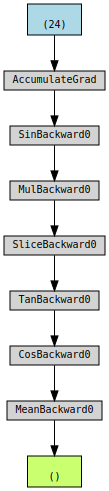

In [14]:
print_graph(loss2)

In [15]:
loss2.backward(retain_graph=True)

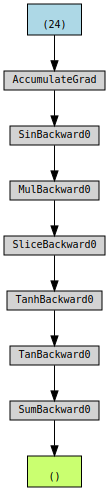

In [16]:
make_dot(loss3, params=dict(model.named_parameters()))

In [17]:
loss3.backward()

In [18]:
print(input.grad)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


In [27]:
input.grad == grad1

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

In [ ]:
===================================

### backward по сумме ошибок

In [20]:
input, loss1, loss2, loss3 = get_losses()

In [21]:
loss1

tensor(0.7820, grad_fn=<SumBackward0>)

In [22]:
loss = loss1+loss2+loss3
loss.backward()
print(input.grad)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


# =====================

In [23]:
input, loss1, loss2, loss3 = get_losses()

In [24]:
loss1 += loss2+loss3

In [25]:
loss1

tensor(-7.7876, grad_fn=<AddBackward0>)

In [26]:
loss1.backward()
print(input.grad)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])
